In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.plotting.register_matplotlib_converters()

import numpy as np
import seaborn as sns
import missingno as mgn

import plotly.express as px

Reading the data with standard preprocessing steps

In [3]:
# Just the new file only - for now
df1 = pd.read_excel('../data/data_d-drivers_2024-03-24.xlsx', sheet_name='data',
                    )
df2 = pd.read_excel('../data/data_d-drivers_2024-03-26.xlsx', sheet_name='data')

df1.columns = [col.lower() for col in df1.columns]
df2.columns = [col.lower() for col in df2.columns]

df1.rename({
           'impressions': 'page_impressions',
           'page_efahrer_id': 'page_id',
           'published_at': 'publishing_date',
           'page_canonical_url': 'url',
           'page_author': 'authors', 
            }, axis=1, inplace=True)

df2.rename({
           'impressions': 'page_impressions',
           'page_efahrer_id': 'page_id',
           'published_at': 'publishing_date',
           'page_canonical_url': 'url',
           'page_author': 'authors', 
            }, axis=1, inplace=True)

What makes each entry unique?

In [ ]:
df1[df1[['page_id', 'date', 'url', 'authors', 'word_count']].duplicated(keep=False)] # keep=False keeps all duplicated values
                                    #.sort_values(['page_id', 'date', 'url', 'page_author'])

,page_id,date,publishing_date,publish_date_equal_to_date,url,page_name,classification_product,classification_type,title,authors,daily_likes,daily_dislikes,word_count,video_play,clickouts,external_clicks,external_impressions
127999,1018299,2024-03-04,NaN,N,https://efahrer.chip.de/news/neuvorstellung-des-fiat-pandina-der-panda-bekommt-ein-geschwisterchen_1018299,efa-1018299 | Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Auto,News,Neuvorstellung des Fiat Pandina: Der Panda bekommt ein Geschwisterchen - EFAHRER.com,JÃ¼rgen Wolff,NaN,NaN,NaN,41.0,0.0,23.0,771.0
128025,1018299,2024-03-04,NaN,N,https://efahrer.chip.de/news/neuvorstellung-des-fiat-pandina-der-panda-bekommt-ein-geschwisterchen_1018299,efa-1018299 | Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Auto,News,Neuvorstellung des Fiat Pandina: Der Panda bekommt ein Geschwisterchen - EFAHRER.com,JÃ¼rgen Wolff,NaN,NaN,NaN,NaN,NaN,NaN,NaN


By experimenting with different sets of columns I found those are 

> 'page_id', 'date', 'url', 'authors', 'word_count'

* NOT the `page_name`: it is totally broken
* NOT the `publishing_date`: sometimes the articles changed several times during the day and the word count changed, so `publishing_date` does not capture all combinations

Addressing the rows by all of those columns makes every article unique but just a single one: 1018299 (rows 66544 and 78658). But the second entry is just a mistake with all missing values, it can be simply dropped. 

In [ ]:
df1.drop(78658, inplace=True)

Merge on those:

In [ ]:
key_columns = ['page_id', 'date', 'url', 'authors', 'word_count']

What columns are in `df1` and not in `df2`?

In [ ]:
print(df2.columns.difference(df1.columns))
print(df1.columns.difference(df2.columns))

Index(['page_impressions'], dtype='object')
Index(['clickouts'], dtype='object')


So the page impressions only present in the 2nd delivery, and clickouts only in the first delivery. 
We will merge the *first to the second*, so in the first dataset we only want to have the key columns and the unique one.

In [ ]:
df1 = df1[key_columns + ['clickouts']]

What pages are in df1 and not in df2 and the other way around?

In [ ]:
print(df1.set_index('page_id').index.difference(df2.set_index('page_id').index))
print(df2.set_index('page_id').index.difference(df1.set_index('page_id').index))

Index([], dtype='int64', name='page_id')
Index([1018667, 1018673, 1018687, 1018743, 1018770, 1018771, 1018776, 1018782], dtype='int64', name='page_id')


> The new data delivery includes all pages from the first one + 8 new ones.

What `URLs` are in df1 and not in df2 and the other way around?

In [ ]:
print(df1.set_index('url').index.difference(df2.set_index('url').index))
print(df2.set_index('url').index.difference(df1.set_index('url').index))

Index([], dtype='object', name='url')
Index(['https://efahrer.chip.de/news/4-module-optionaler-speicher-haendler-setzt-balkonkraftwerk-auf-799-euro-runter_1017455',
       'https://efahrer.chip.de/news/ampeln-mit-neuer-farbe-weiss-will-das-leben-aller-verkehrsteilnehmer-verbessern_1011583',
       'https://efahrer.chip.de/news/angebot-nur-bis-ostern-so-bekommen-sie-1000-euro-rabatt-auf-ihre-solaranlage_1018573',
       'https://efahrer.chip.de/news/auch-mit-halterung-bei-diesem-balkonkraftwerk-preis-schlucken-selbst-discounter_1014858',
       'https://efahrer.chip.de/news/batterie-geheimnisse-maenner-sollen-tesla-bestohlen-und-firma-gegruendet-haben_1018770',
       'https://efahrer.chip.de/news/buegelschloss-mit-fingerabdrucksensor-bei-aldi_1013493',
       'https://efahrer.chip.de/news/dashcam-schnaeppchen-bei-amazon-das-taugt-die-kamera-fuer-unter-40-euro_1018667',
       'https://efahrer.chip.de/news/e-auto-fahrer-sind-fein-raus-deutsches-gericht-erzwingt-schaerfere-fahrverbote_10

> 22 new URLs

Which dates are new?

In [ ]:
print(df1.set_index('date').index.difference(df2.set_index('date').index))
print(df2.set_index('date').index.difference(df1.set_index('date').index))

Index(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05',
       '2023-01-06', '2023-01-07', '2023-01-08', '2023-01-09', '2023-01-10',
       ...
       '2024-03-13', '2024-03-14', '2024-03-15', '2024-03-16', '2024-03-17',
       '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21', '2024-03-22'],
      dtype='object', name='date', length=447)
DatetimeIndex(['2024-03-23'], dtype='datetime64[ns]', name='date', freq=None)


> The day between the first and the second data deliveries, makes a lot of sense :D

In [ ]:
if df1.shape == df1.drop_duplicates().shape:
    print('No duplicates left in the first dataframe')
else: 
    print('Duplicated entries present: merging will blow up the data frame size')

No duplicates left in the first dataframe


In [ ]:
if df2[key_columns].shape == df2[key_columns].drop_duplicates().shape:
    print('No duplicates are in the second dataframe')
else: 
    print('Duplicated entries present: merging will blow up the data frame size')

Duplicated entries present: merging will blow up the data frame size


In [ ]:
df2[df2[key_columns].duplicated(keep=False)] # keep=False keeps all duplicated values
                                    #.sort_values(['page_id', 'date', 'url', 'page_author'])

,page_id,date,publishing_date,publish_date_equal_to_date,url,page_name,classification_product,classification_type,title,authors,daily_likes,daily_dislikes,word_count,video_play,page_impressions,external_clicks,external_impressions
40600,1018299,2024-03-04,NaT,N,https://efahrer.chip.de/news/neuvorstellung-des-fiat-pandina-der-panda-bekommt-ein-geschwisterchen_1018299,efa-1018299 | Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Auto,News,Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Jürgen Wolff,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107004,1018299,2024-03-04,NaT,N,https://efahrer.chip.de/news/neuvorstellung-des-fiat-pandina-der-panda-bekommt-ein-geschwisterchen_1018299,efa-1018299 | Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Auto,News,Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Jürgen Wolff,NaN,NaN,NaN,41.0,72.0,23.0,771.0


Same mistake is in `df2`: remove it.

In [ ]:
df2.drop(40600, inplace=True)

In [ ]:
if df2[key_columns].shape == df2[key_columns].drop_duplicates().shape:
    print('No duplicates are in the second dataframe')
else: 
    print('Duplicated entries present: merging will blow up the data frame size')

No duplicates are in the second dataframe


In [ ]:
# Because a the data for df1 is imported from a csv and for df2 from an excel sheet, the data types differ. 
# To avoid conflicts when merging, let's change the column type from object to date for the date column in df1.
df1["date"] = pd.to_datetime(df1["date"])
print(df1.dtypes)
print(df2.dtypes)

page_id                int64
date          datetime64[ns]
url                   object
authors               object
word_count           float64
clickouts            float64
dtype: object
page_id                                int64
date                          datetime64[ns]
publishing_date               datetime64[ns]
publish_date_equal_to_date            object
url                                   object
page_name                             object
classification_product                object
classification_type                   object
title                                 object
authors                               object
daily_likes                          float64
daily_dislikes                       float64
word_count                           float64
video_play                           float64
page_impressions                     float64
external_clicks                      float64
external_impressions                 float64
dtype: object


Yuppi, now we are ready to merge!

## Merging

Using the `left` merging: we already know that `df1` is malformatted

In [ ]:
df = pd.merge(left=df2, right=df1, on=key_columns, how='left') 
# in principle, even the page_id is redundant in this case, 
# because each url contains the page id as the suffix

df

,page_id,date,publishing_date,publish_date_equal_to_date,url,page_name,classification_product,classification_type,title,authors,daily_likes,daily_dislikes,word_count,video_play,page_impressions,external_clicks,external_impressions,clickouts
0,1010803,2023-01-02,NaT,N,https://efahrer.chip.de/news/tariferhoehungen-und-thg-praemie-ladesaeulenbetreiber-ziehen-kunden-ueber-den-tisch_1010803,efa-1010803 | Tariferhöhungen und THG-Prämie: Ladesäulenbetreiber ziehen Kunden über den Tisch,THG,News,Tariferhöhungen und THG-Prämie: Ladesäulenbetreiber ziehen Kunden über den Tisch,Karl Lüdecke,NaN,NaN,NaN,1261.0,1375.0,1301.0,20323.0,NaN
1,1010592,2023-01-02,NaT,N,https://efahrer.chip.de/news/das-logo-von-alfa-romeo-wofuer-stehen-schlange-und-kreuz_1010592,efa-1010592 | Alfa Romeo: Was bedeuten Schlange und Kreuz?,Auto,News,Alfa Romeo: Was bedeuten Schlange und Kreuz?,Karl Müller,NaN,NaN,NaN,286.0,298.0,164.0,1493.0,NaN
2,1010719,2023-01-05,NaT,N,https://efahrer.chip.de/news/titel-ist-zurueck-in-deutschland-forscher-entwickeln-effizienteste-solarzelle_1010719,efa-1010719 | Rennen um die effizienteste Solarzelle: Deutsche holen sich den Titel zurück,Solaranlagen,News,Rennen um die effizienteste Solarzelle: Deutsche holen sich den Titel zurück,Aslan Berse,NaN,NaN,NaN,156.0,300.0,303.0,4912.0,0.0
3,1010727,2023-01-05,NaT,N,https://efahrer.chip.de/news/entlastungen-fuer-heizoel-kunden-wer-keinen-antrag-stellt-bekommt-gar-nichts_1010727,efa-1010727 | Antrag stellen oder leer ausgehen: Diese Entlastung ist für Heizöl-Kunden geplan,Energie,Ratgeber,Antrag stellen oder leer ausgehen: Diese Entlastung ist für Heizöl-Kunden geplan,CHIP,NaN,NaN,NaN,16.0,55.0,14009.0,92422.0,0.0
4,1010557,2023-01-02,2023-01-02,Y,https://efahrer.chip.de/news/solaranlage-auch-fuer-mieter-das-sind-die-besten-modelle-fuer-ihren-balkon_1010557,efa-1010557 | Balkonkraftwerk kaufen: Das sind die besten Modelle,Balkonkraftwerk,Kaufberatung,Balkonkraftwerk kaufen: Das sind die besten Modelle,Eva Goldschald,17.0,1.0,1513.0,174.0,128.0,6494.0,114984.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132840,1010297,2023-11-17,2023-11-17,Y,https://efahrer.chip.de/news/hammer-preis-fuer-hammer-auto-hyundai-ioniq-6-schon-fuer-200-euro-im-leasing_1010297,efa-1010297 | Hyundai IONIQ 6 Deal,E-Auto,Deal,Hyundai IONIQ 6 Deal,Lisa Brack,0.0,0.0,725.0,1.0,1.0,905.0,12463.0,0.0
132841,1014887,2023-12-31,2023-12-13,N,https://efahrer.chip.de/news/aldi-verkauft-rueckfahrkamera-fuers-auto-der-selbsteinbau-soll-ein-klacks-sein_1014887,efa-1014887 | Aldi verkauft Rückfahrkamera fürs Auto: Der Selbsteinbau soll ein Klacks sein,Zubehör,Deal,Aldi verkauft Rückfahrkamera fürs Auto: Der Selbsteinbau soll ein Klacks sein,Vanessa Finkler,0.0,0.0,535.0,0.0,1.0,95.0,1048.0,0.0
132842,105946,2024-01-18,2024-01-16,N,https://efahrer.chip.de/news/guenstiges-e-auto-trotz-praemien-aus-bei-diesen-neuwagen-sparen-sie-am-meisten_105946,"efa-105946 | E-Autos mit kurzer Lieferzeit: Fiat 500e, Polestar 2, Renault Twingo und mehr",E-Auto,Deal,"E-Autos mit kurzer Lieferzeit: Fiat 500e, Polestar 2, Renault Twingo und mehr",Benjamin Dizdar,0.0,0.0,2142.0,0.0,1.0,10.0,106.0,0.0
132843,1014127,2023-08-17,NaT,N,https://efahrer.chip.de/news/urlaubshoelle-in-italien-deutscher-strandet-mit-billigem-e-auto_1014127,efa-1014127 | Urlaubshölle in Italien: Deutsche stranden mit billigem E-Auto,E-Auto,News,Urlaubshölle in Italien: Deutsche stranden mit billigem E-Auto,Vanessa Finkler,NaN,NaN,NaN,0.0,1.0,5820.0,83900.0,0.0


In [ ]:
df2.shape

(132845, 17)

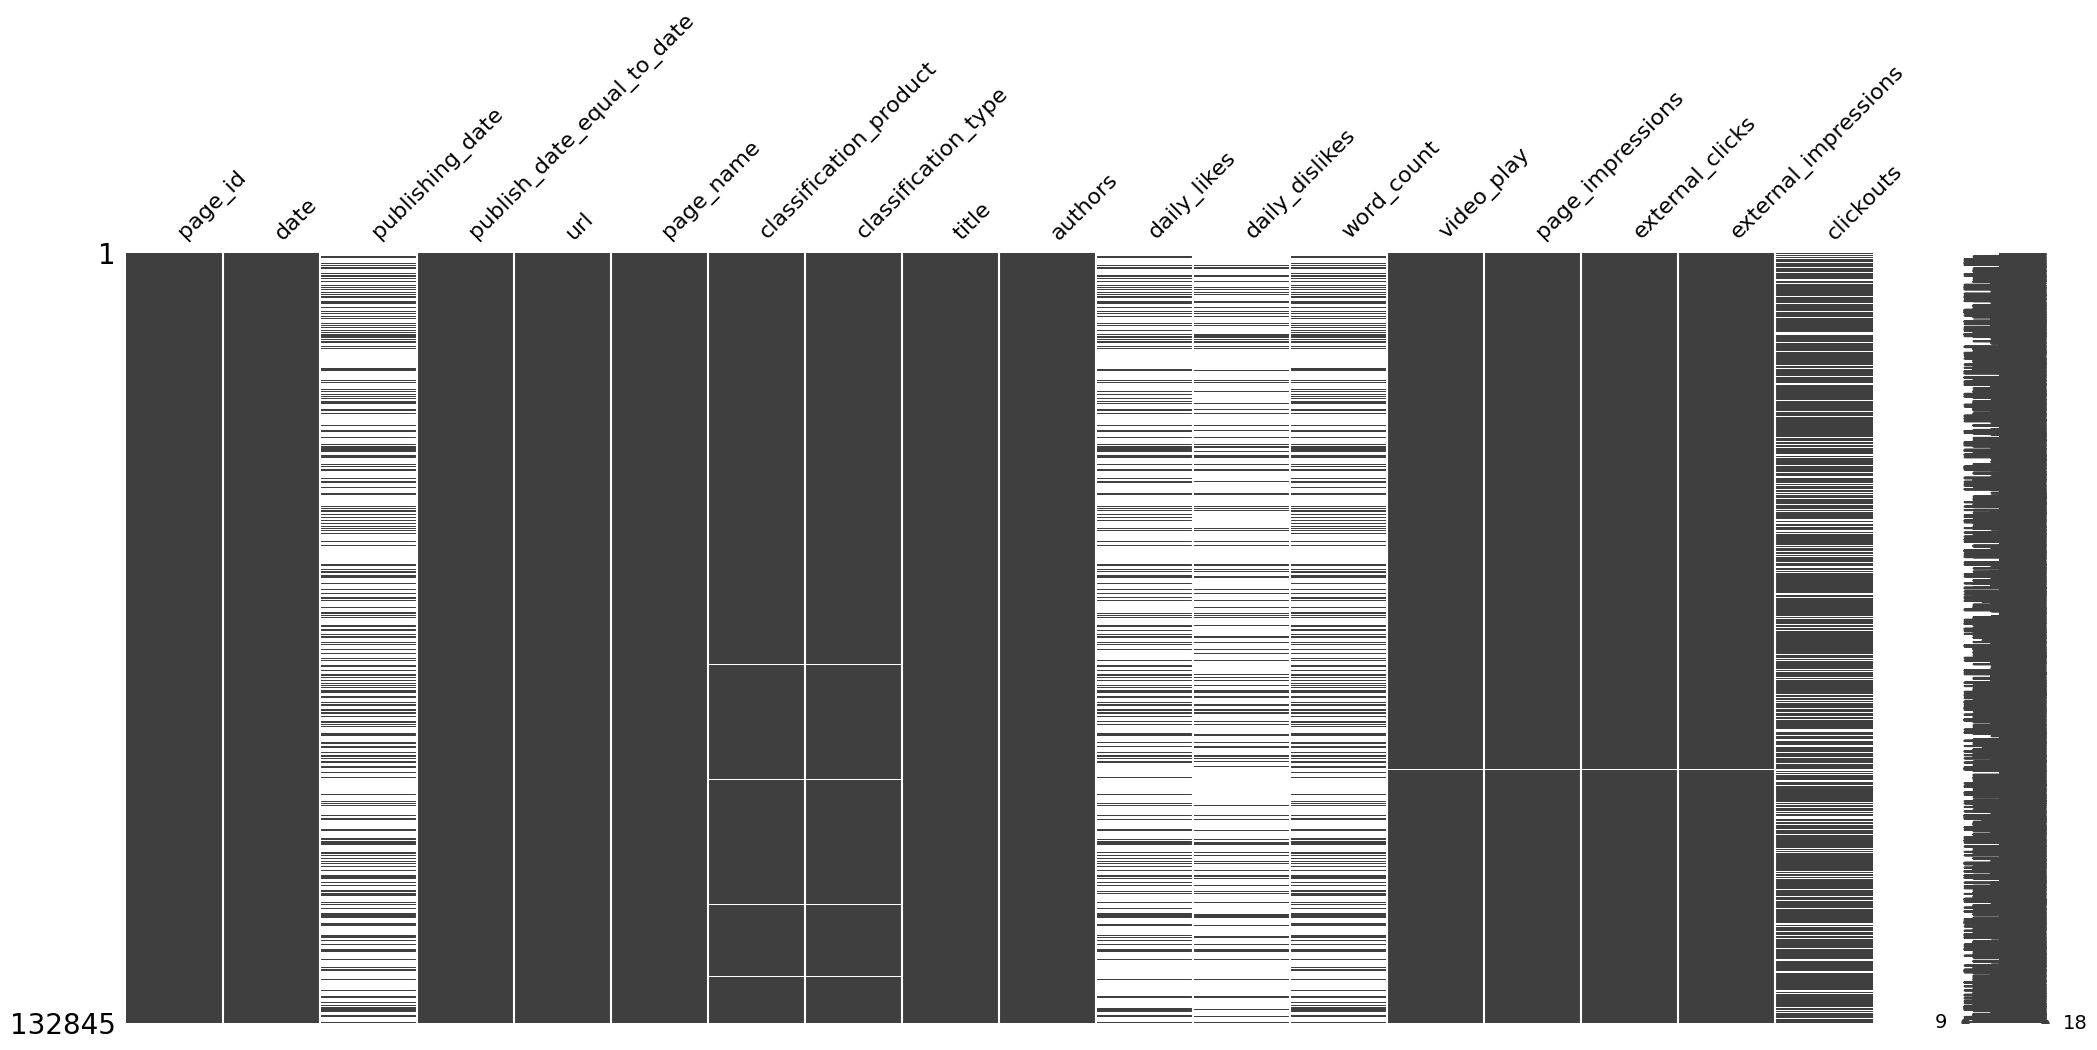

In [ ]:
mgn.matrix(df);

### Merging in the scraped data

In [ ]:
## To be continued

Cleaning up

In [ ]:
del df1
del df2

## Imputing

In [ ]:
df = df.sort_values(['page_id', 'date', 'publishing_date', 'url']).reset_index(drop=True)

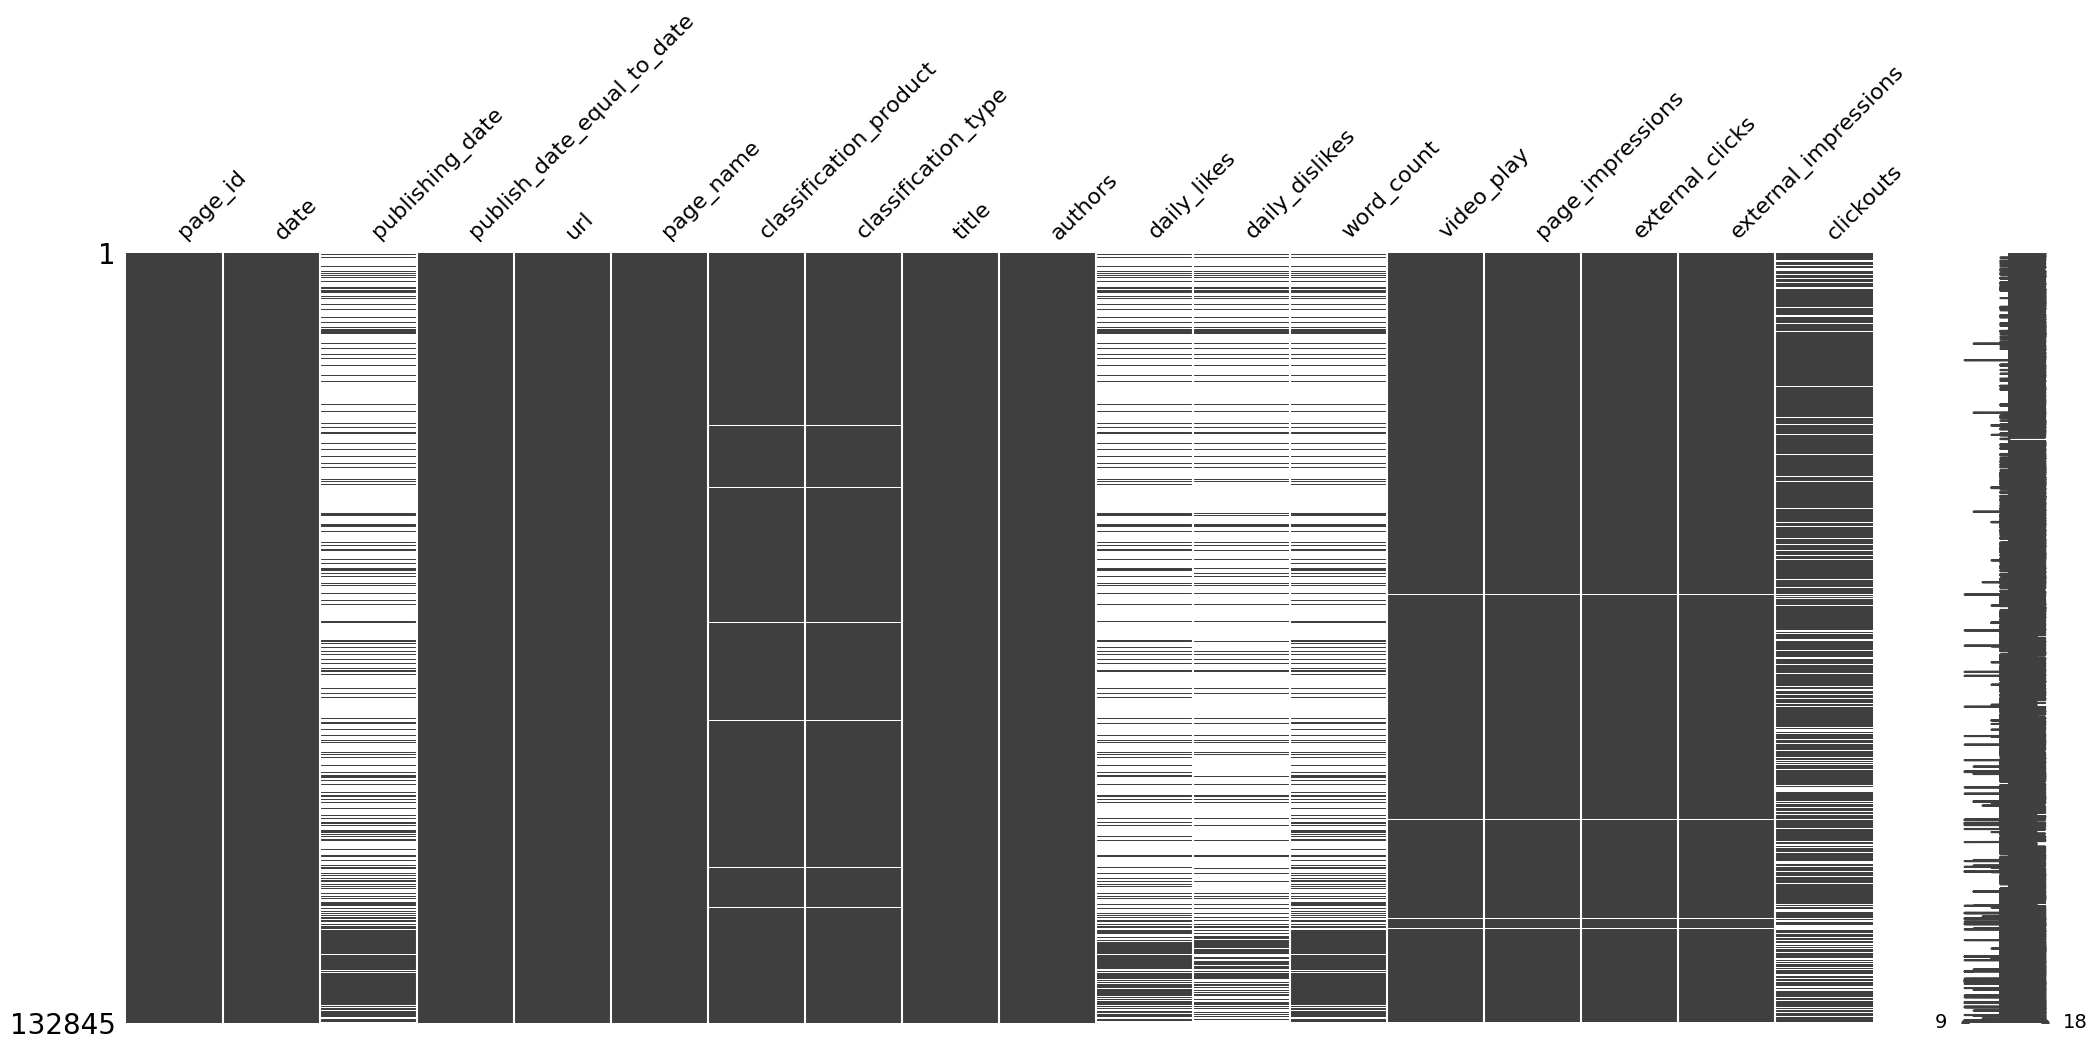

In [ ]:
mgn.matrix(df);

#### Article versions

In [ ]:
df[(df['publish_date_equal_to_date'] == 'Y') & (df['publishing_date'].isna())]

,page_id,date,publishing_date,publish_date_equal_to_date,url,page_name,classification_product,classification_type,title,authors,daily_likes,daily_dislikes,word_count,video_play,page_impressions,external_clicks,external_impressions,clickouts


Attention: some articles were scheduled for an update (or first publication), therefore have already existing entries and stats (likes, dislikes, etc.)

In [ ]:
scheduled_articles = df.query('date < publishing_date')#[df.columns.drop(['url', 'title', 'page_name'])]

In [ ]:
scheduled_articles_ids = scheduled_articles.page_id.unique()

In [ ]:
# Grouping, so we are not filling in the values from other articles!
versions = df.groupby(['page_id'], as_index=False, sort=True)[
    ['page_id', 'date', 'publishing_date', 'word_count']
    ].ffill()
#versions.rename({'index': 'page_id'}, axis=1, inplace=True)
versions

,page_id,date,publishing_date,word_count
0,1037,2024-03-13,2024-03-10,827.0
1,1037,2024-03-13,2024-03-10,827.0
2,1037,2024-03-14,2024-03-10,827.0
3,1037,2024-03-15,2024-03-10,827.0
4,1037,2024-03-16,2024-03-10,827.0
...,...,...,...,...
132840,1018768,2024-03-23,NaT,NaN
132841,1018770,2024-03-23,NaT,NaN
132842,1018771,2024-03-23,NaT,NaN
132843,1018776,2024-03-23,NaT,NaN


In [ ]:
versions.query('date < publishing_date').shape[0] == scheduled_articles.shape[0]

False

**Assuming that all articles which don't have a publishing date but were scheduled for an update are actually REALLY OLD and were published at the around inception of EFAHRER (01-01-2016)

In [ ]:
wtf_idx = versions.query('date < publishing_date').index.difference(scheduled_articles.index)
wtf_idx

Index([14802, 54942, 54943, 54944, 54945, 67690, 67691, 91857], dtype='int64')

In [ ]:
pd.Timestamp('2016-01-01 00:00:00')

Timestamp('2016-01-01 00:00:00')

In [ ]:
df[df.date < df.publishing_date]

,page_id,date,publishing_date,publish_date_equal_to_date,url,page_name,classification_product,classification_type,title,authors,daily_likes,daily_dislikes,word_count,video_play,page_impressions,external_clicks,external_impressions,clickouts
9142,105345,2023-01-12,2023-01-13,N,https://efahrer.chip.de/solaranlagen/strom-clouds-so-horten-sie-strom-fuer-den-winter_105345,efa-105345 | Der Winter kommt: So horten Solar-Besitzer jetzt noch genug Strom,Solaranlagen,Kaufberatung,Der Winter kommt: So horten Solar-Besitzer jetzt noch genug Strom,Sebastian Barsch,6.0,0.0,1939.0,0.0,164.0,95.0,3017.0,18.0
14068,107173,2023-07-13,2023-07-14,N,https://efahrer.chip.de/news/der-beste-thg-anbieter-im-check-warum-elektrovorteil-wieder-sieger-wurde_107173,efa-107173 | THG-Anbieter Elektrovorteil im Schnell-Check: Das ist der THG-Testsieger im März,THG,Kaufberatung,THG-Anbieter Elektrovorteil im Schnell-Check: Das ist der THG-Testsieger im März,Hannah Anhorn/Franziska Auner,0.0,0.0,937.0,2.0,7.0,34.0,407.0,1.0
14800,107341,2023-01-13,2023-01-16,N,https://efahrer.chip.de/news/geero-2-im-deal-wo-sie-das-city-e-bike-gerade-guenstiger-kriegen_107341,efa-107341 | Limitierte Oster-Edition: Manufaktur bringt leichtes E-Bike für kurze Zeit,E-Bike,Deal,Limitierte Oster-Edition: Manufaktur bringt leichtes E-Bike für kurze Zeit,Sebastian Barsch,0.0,0.0,602.0,77.0,219.0,1991.0,60853.0,9.0
14801,107341,2023-01-13,2023-01-16,N,https://efahrer.chip.de/news/ist-das-wirklich-ein-e-bike-ueber-500-euro-rabatt-auf-tarn-pedelec-von-geero_107341,efa-107341 | Limitierte Oster-Edition: Manufaktur bringt leichtes E-Bike für kurze Zeit,E-Bike,Deal,Limitierte Oster-Edition: Manufaktur bringt leichtes E-Bike für kurze Zeit,Sebastian Barsch,0.0,0.0,602.0,1.0,4.0,1991.0,60853.0,2.0
47879,1011437,2023-04-21,2023-04-22,N,https://efahrer.chip.de/news/thg-anbieter-emobilityenergy-im-check-zocker-kriegen-hier-bis-zu-411-euro_1011437,efa-1011437 | emobility energy deal,THG,Deal,emobility energy deal,Gabriel Wessel,0.0,0.0,918.0,1.0,3.0,174.0,4217.0,0.0
47886,1011437,2023-07-13,2023-07-14,N,https://efahrer.chip.de/news/thg-anbieter-emobilityenergy-im-check-411-euro-fuer-mutige-e-auto-fahrer_1011437,efa-1011437 | emobility energy deal,THG,Deal,emobility energy deal,Gabriel Wessel,0.0,1.0,882.0,21.0,37.0,50.0,743.0,1.0
54939,1011759,2023-05-19,2023-05-22,N,https://efahrer.chip.de/news/eine-waermepumpe-fuer-den-80er-jahre-bungalow-youtuber-zeigt-seinen-verbrauch_1011759,efa-1011759 | Wärmepumpe im unsanierten 80er Jahre-Bungalow: Hausbesitzer zieht Winterbilanz,Wärmepumpe,News,Wärmepumpe im unsanierten 80er Jahre-Bungalow: Hausbesitzer zieht Winterbilanz,Aslan Berse,0.0,0.0,698.0,123.0,84.0,415.0,3418.0,0.0
54940,1011759,2023-05-19,2023-05-22,N,https://efahrer.chip.de/news/waermepumpe-im-winter-altbau-bewohner-mit-eiskaltem-urteil_1011759,efa-1011759 | Wärmepumpe im unsanierten 80er Jahre-Bungalow: Hausbesitzer zieht Winterbilanz,Wärmepumpe,News,Wärmepumpe im unsanierten 80er Jahre-Bungalow: Hausbesitzer zieht Winterbilanz,Aslan Berse,0.0,0.0,698.0,0.0,1.0,415.0,3418.0,0.0
54941,1011759,2023-05-19,2023-05-22,N,https://efahrer.chip.de/news/youtuber-benutzt-waermepumpe-fuer-80er-jahre-bungalow-das-ist-seine-winter-bilanz_1011759,efa-1011759 | Wärmepumpe im unsanierten 80er Jahre-Bungalow: Hausbesitzer zieht Winterbilanz,Wärmepumpe,News,Wärmepumpe im unsanierten 80er Jahre-Bungalow: Hausbesitzer zieht Winterbilanz,Aslan Berse,0.0,0.0,698.0,0.0,1.0,415.0,3418.0,0.0
67689,1012516,2023-04-26,2023-04-29,N,https://efahrer.chip.de/news/heizen-mit-klimaanlage-energiespar-profi-spricht-klartext_1012516,efa-1012516 | Heizen mit Klimaanlage: Energiespar-Profi spricht Klartext,Wärmepumpe,Erfahrungsbericht,Heizen mit Klimaanlage: Energiespar-Profi spricht Klartext,Kai Grossjohann,NaN,NaN,568.0,10237.0,13733.0,43621.0,483050.0,1.0


In [ ]:
versions[(versions.date < versions.publishing_date)]

,page_id,date,publishing_date,word_count
9142,105345,2023-01-12,2023-01-13,1939.0
14068,107173,2023-07-13,2023-07-14,937.0
14800,107341,2023-01-13,2023-01-16,602.0
14801,107341,2023-01-13,2023-01-16,602.0
14802,107341,2023-01-15,2023-01-16,602.0
47879,1011437,2023-04-21,2023-04-22,918.0
47886,1011437,2023-07-13,2023-07-14,882.0
54939,1011759,2023-05-19,2023-05-22,698.0
54940,1011759,2023-05-19,2023-05-22,698.0
54941,1011759,2023-05-19,2023-05-22,698.0


In [ ]:
versions[(versions.date < versions.publishing_date)].page_id.unique()

array([ 105345,  107173,  107341, 1011437, 1011759, 1012516, 1014312])

For some pages we simply don't know the date of first publication! We need to impute it for modelling, but how we do it may depend on the model.

Which articles are those?

In [ ]:
no_publ_date = versions[versions.publishing_date.isna()].page_id.unique()
no_publ_date

array([  10245,   10273,   10372, ..., 1018771, 1018776, 1018782])

In [ ]:
no_publ_date.shape 

(2319,)

In [ ]:
len(no_publ_date) / len(df.page_id.unique())

0.33613567183649806

So those entries comprise almost 34 % of all articles :(

Merging the imputed columns back in:

In [ ]:
versions.columns

Index(['page_id', 'date', 'publishing_date', 'word_count'], dtype='object')

In [ ]:
df.columns.drop('publishing_date').drop('word_count')

Index(['page_id', 'date', 'publish_date_equal_to_date', 'url', 'page_name',
       'classification_product', 'classification_type', 'title', 'authors',
       'daily_likes', 'daily_dislikes', 'video_play', 'page_impressions',
       'external_clicks', 'external_impressions', 'clickouts'],
      dtype='object')

In [ ]:
df_imputed = pd.merge(df[df.columns.drop('publishing_date').drop('word_count')], # drop the non-imputed columns
                      versions[['page_id', 'date', 'publishing_date', 'word_count']], # include the relevant columns only
                      on=['page_id', 'date'], how='left')

<Axes: >

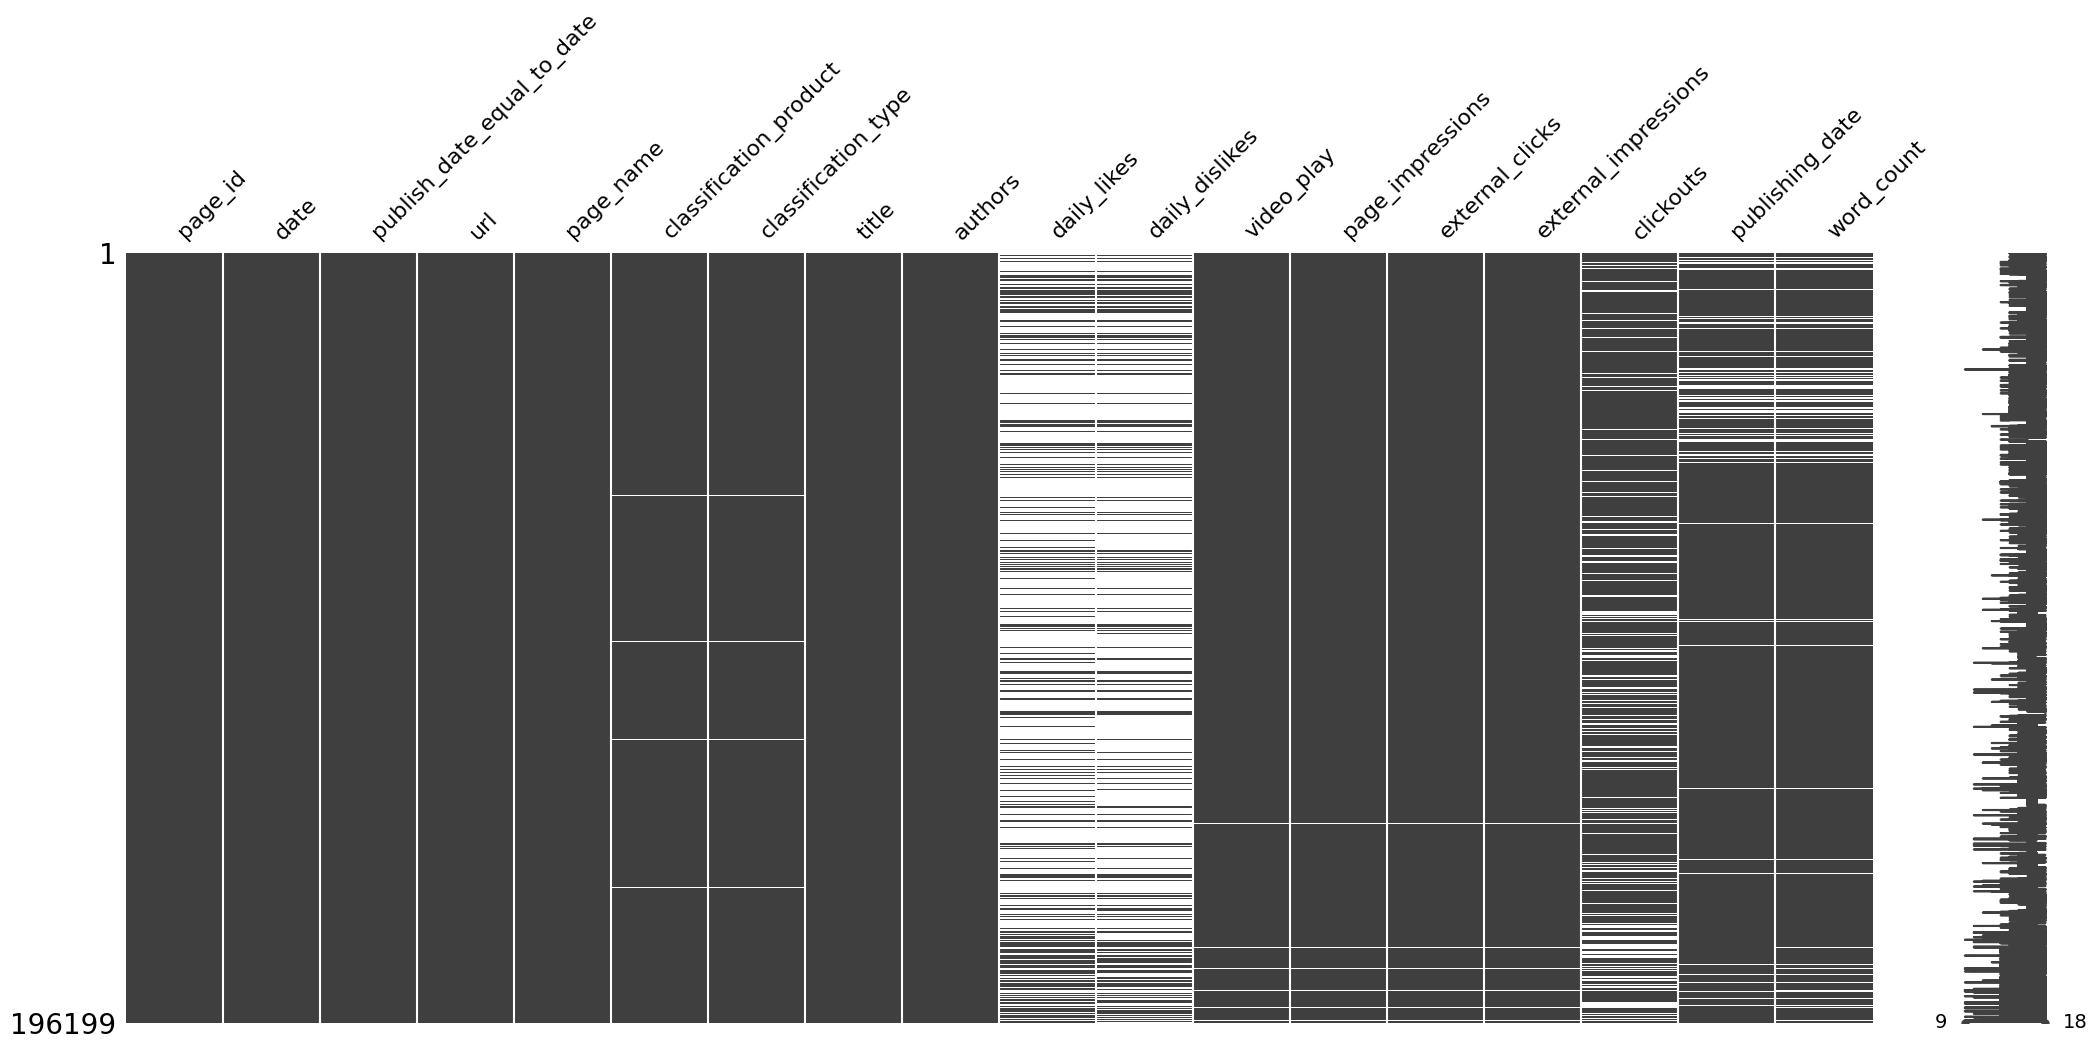

In [ ]:
mgn.matrix(df_imputed)

#### Daily reactions

In [ ]:
df['daily_likes']

0         0.0
1         0.0
2         0.0
3         0.0
4         1.0
         ... 
132840    NaN
132841    NaN
132842    NaN
132843    NaN
132844    NaN
Name: daily_likes, Length: 132845, dtype: float64

---

## Feature engineering

### Article (content) versions

We want to label each version.
* Version changes when there is a new `publication date`
* Version changes when there is a new `word count`
* Version does NOT change with a change in `URL`
* Version does NOT change with a change in the `date` column

In [ ]:
# Only the necessary columns
# we still need the 'date' column for imputation
df_cnt = df[['page_id', 'date', 'publishing_date', 'word_count']]
df_cnt = df_cnt.sort_values(['page_id', 'date', 'publishing_date'])
df_cnt

,page_id,date,publishing_date,word_count
0,1037,2024-03-13,2024-03-10,827.0
1,1037,2024-03-13,2024-03-10,827.0
2,1037,2024-03-14,2024-03-10,827.0
3,1037,2024-03-15,2024-03-10,827.0
4,1037,2024-03-16,2024-03-10,827.0
...,...,...,...,...
132840,1018768,2024-03-23,NaT,NaN
132841,1018770,2024-03-23,NaT,NaN
132842,1018771,2024-03-23,NaT,NaN
132843,1018776,2024-03-23,NaT,NaN


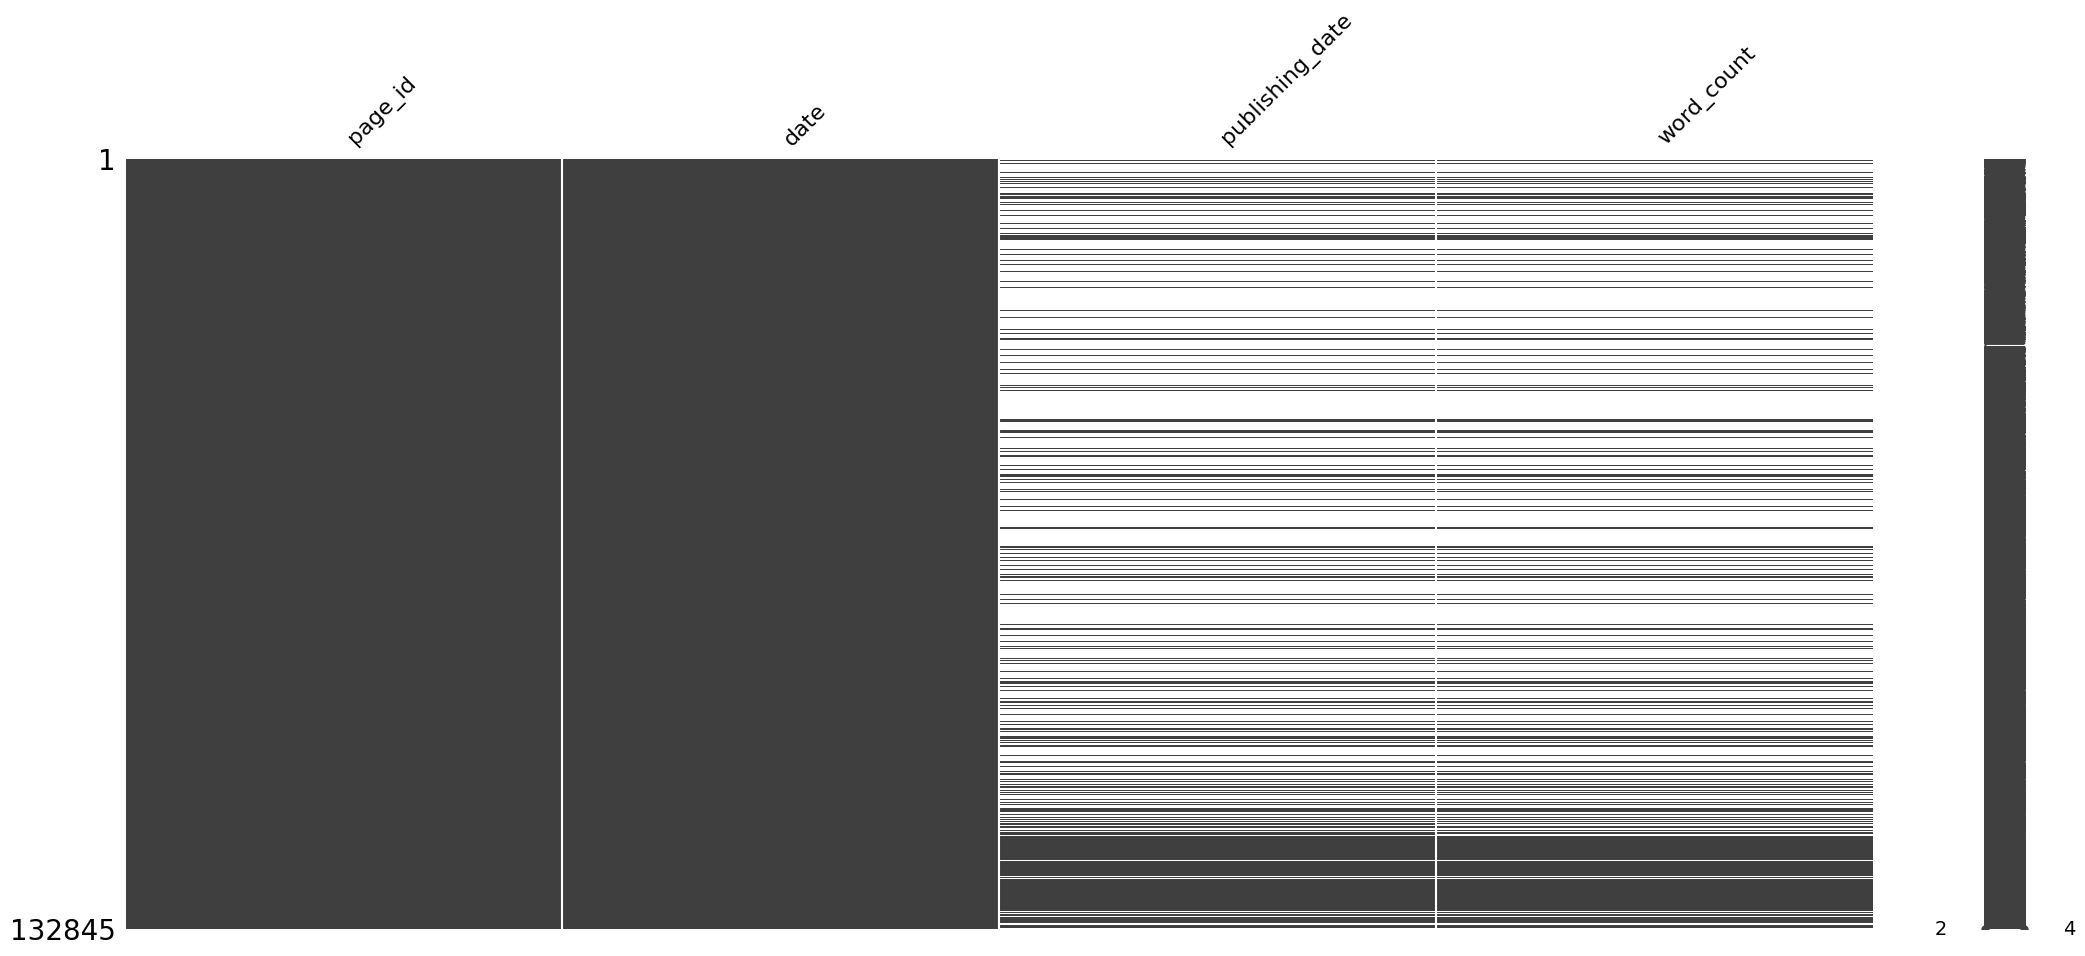

In [ ]:
mgn.matrix(df_cnt);

There are some columns where the publication date changed but the `word count` was not updated!

In [ ]:
wcna_idx = df_cnt[df_cnt.word_count.isna() & df_cnt.publishing_date.notna()].index
wcna_idx

Index([ 15641,  27554,  27556,  27557,  27558,  27559,  27560,  27561,  27562,
        44631,
       ...
       132341, 132342, 132343, 132344, 132345, 132346, 132347, 132704, 132705,
       132757],
      dtype='int64', length=472)

NOT the other way around:

In [ ]:
df_cnt[df_cnt.word_count.notna() & df_cnt.publishing_date.isna()].index

Index([], dtype='int64')

The best assumption that it did not change (significantly??), so still forward-fill it.

In [ ]:
df_cnt = df_cnt.ffill()

In [ ]:
sus = df_cnt.loc[wcna_idx]

#### Versions

In [ ]:
df_cnt['publ_at_enc'] = df_cnt.groupby('page_id')['publishing_date'].transform(lambda x: pd.factorize(x)[0])
df_cnt

,page_id,date,publishing_date,word_count,publ_at_enc
0,1037,2024-03-13,2024-03-10,827.0,0
1,1037,2024-03-13,2024-03-10,827.0,0
2,1037,2024-03-14,2024-03-10,827.0,0
3,1037,2024-03-15,2024-03-10,827.0,0
4,1037,2024-03-16,2024-03-10,827.0,0
...,...,...,...,...,...
132840,1018768,2024-03-23,2024-03-21,349.0,0
132841,1018770,2024-03-23,2024-03-21,349.0,0
132842,1018771,2024-03-23,2024-03-21,349.0,0
132843,1018776,2024-03-23,2024-03-21,349.0,0


How many versions does each article have?

In [ ]:
to_plot = df_cnt[['page_id', 'publ_at_enc']].groupby('page_id').max()#.reset_index()
first_publ_date = df_cnt[['page_id', 'publishing_date']].groupby('page_id').min()
first_publ_date = first_publ_date.rename({'publishing_date': 'First publication date'}, axis=1)
to_plot = to_plot.join(first_publ_date)
to_plot = to_plot.rename({'publ_at_enc': 'Number of versions'}, axis=1)
to_plot

,Number of versions,First publication date
page_id,,
1037,0,2024-03-10
1039,0,2022-05-05
1040,0,2024-02-21
10245,0,2024-02-21
10273,4,2023-11-29
...,...,...
1018768,0,2024-03-21
1018770,0,2024-03-21
1018771,0,2024-03-21


In [ ]:
px.scatter(data_frame=to_plot, x='Number of versions', y='First publication date')

Article with 61 (!!!) versions:

In [ ]:
metrics_cols = ['url', 'daily_likes', 
               'daily_dislikes', 'page_impressions', 'video_play', 
               'external_clicks', 'external_impressions']

In [ ]:
article105259 = df[df['page_id']==105259].sort_values(['date', 'url'])
article_first_url = article105259[metrics_cols + ['date']].drop_duplicates(subset=['date'], keep='first')

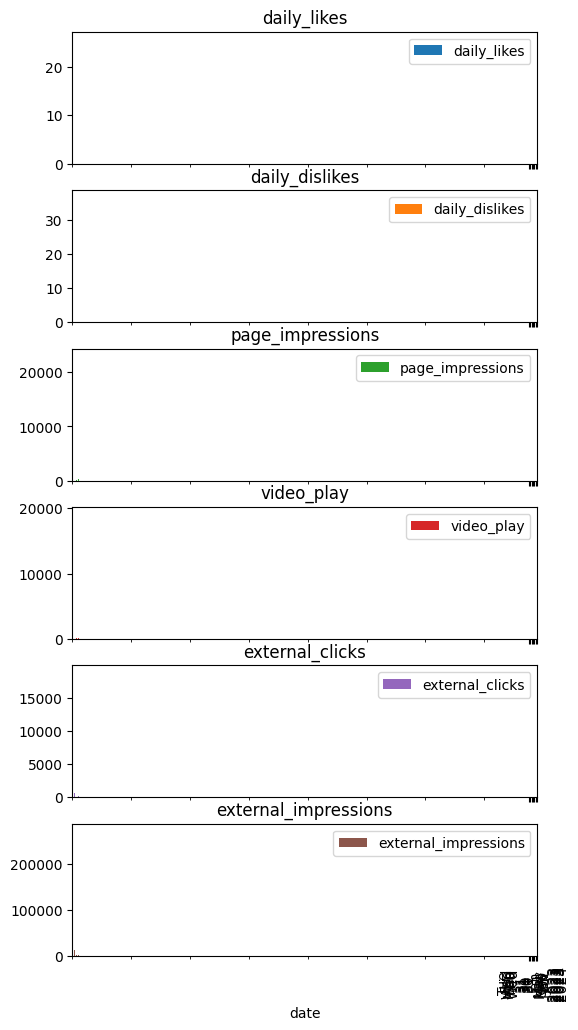

In [ ]:
import matplotlib.pyplot as plt

xticks=pd.date_range(df.date.min(), df.date.max(), freq='2M')
fig = article_first_url.plot(kind='bar', x='date', y=metrics_cols, subplots=True, figsize=(6, 12), 
                       xticks=xticks)
plt.gca().set_xticklabels([x.strftime('%a\n%d\n%h\n%Y') for x in xticks]);
# plt.xticks(ticks=df[['page_impressions', 'publishing_date']].resample('W', on='publishing_date').max().index);
# plt.xticks(ticks=pd.date_range(df.date.min(), df.date.max(), freq='2M'),
#            labels=pd.date_range(df.date.min(), df.date.max(), freq='2M'));